In [1]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm

from scipy.interpolate import interp1d



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table, vstack

from ResidualUtils import getwavs, getspecpath, getapstarpath



matplotlib.rcParams.update({'xtick.labelsize':15,
                            'ytick.labelsize':15,
                            'axes.titlesize':15,
                            'axes.labelsize':15,
                            'font.size':15,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})
# plt.rcParams['pgf.texsystem'] = 'pdflatex'



flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

In [2]:
# Read in some useful tables:
# tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
tabfile = 'allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1) # allStarLite base file


# select all CA Cloud stars from the allStarLite file
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]
# for our purposes, requires that all CA cloud stars have TEFF, LOGG, and M_H

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]] # clean up the allStarLite data file

In [3]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

# if I change the data structure, I'll make an equivalent get_residual function
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu # may want to make it return the path

In [4]:
# get aspcapStar file path from an allstar table row
def get_aspcapStar(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    path = '/Users/aidanmcbride/Documents/ISM/Files/aspcap/' + specname.format(SOURCEID = sourceid) # LOCAL MACHINE ONLY
    return path

# get apStar/asStar file path from an aspcapStar hdulist
def get_apStar(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    path = '/Users/aidanmcbride/Documents/ISM/Files/apstar/' + fname # LOCAL MACHINE ONLY
    return path

# get wavelength array for some aspcapStar/apStar hdulist; if no hdulist given, uses default values
# can be rv-corrected from the stellar rest frame to the observed frame
def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs 

# creates a mask from pixel-wise apStar/asStar bitmask
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []): 
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

In [5]:
cols = ['APOGEE_ID', 'TELESCOPE', 'FIELD', 'RA', 'DEC', 'GLON', 'GLAT', 'ASCAP_CHI2',
        'J', 'H', 'K', 'VHELIO_AVG', 'GAIAEDR3_PARALLAX', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M']

-1.3347823405852859
23.565107


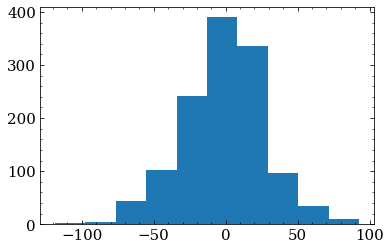

In [6]:
wavs = getwavs()
print(np.mean(CA_clean['VHELIO_AVG']))
print(CA_clean['VHELIO_AVG'][0])

plt.hist(CA_clean['VHELIO_AVG'])
plt.show()


In [7]:
star = CA_clean[0]
print(star['TEFF'], star['LOGG'], star['M_H'])
get_residual(star['TEFF'], star['LOGG'], star['M_H'])

5961.021 4.321162 0.084895


In [26]:
n = len(CA_clean)
nbin = np.zeros(n)

from os.path import exists

wavs = get_wavs()

for i in range(len(CA_clean)):
    row = CA_clean[i]
    apogee_id = row['APOGEE_ID']
    telescope = row['TELESCOPE']
    field = row['FIELD']
    rv = row['VHELIO_AVG']
    

    aspcap_fname = get_aspcapStar(row)
    if not exists(aspcap_fname):
        continue
    aspcap = fits.open(get_aspcapStar(row))
    apstar = fits.open(get_apStar(aspcap))
    medres = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
    
    bitmask = apstar[3].data[0]
    
    spectrum = aspcap[1].data
    model = aspcap[3].data
    residual_uncorrected = spectrum / model
    
    median_residual = medres.data[0]
    n_pix = medres.data[6]
    residual = residual_uncorrected / median_residual
    
    data = [residual, median_residual, bitmask, wavs]
    data_names = ['stellar residual', 'median residual', 'bitmask', 'wavelength']
    
    hdu0 = fits.PrimaryHDU()
    hdu0.header['APOGEE_ID'] = apogee_id
    hdu0.header['TELESCOPE'] = telescope
    hdu0.header['FIELD'] = field
    
    hdulist = fits.HDUList([hdu0])
    for j in range(len(data)):
        hduj = fits.ImageHDU(data[j])
        
        hduj.header['NAME'] = data_names[j]
        # hduj.header['']
        
        
        hdulist.append(hduj)
    print('hi it worked')
    # hdulist.write_to('CACloudResiduals/res_{id}.fits'.format(id = apogee_id), overwrite = True)
    break

hi it worked


/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_36042/696523404.py:25: RuntimeWarning: invalid value encountered in true_divide
  residual_uncorrected = spectrum / model


In [50]:
wavs = get_wavs()
wavs_rv = get_wavs(rv = rv)

interp = interp1d(wavs_rv, spectrum, kind = 'slinear', bounds_error = False)

spec_interp = interp(wavs)

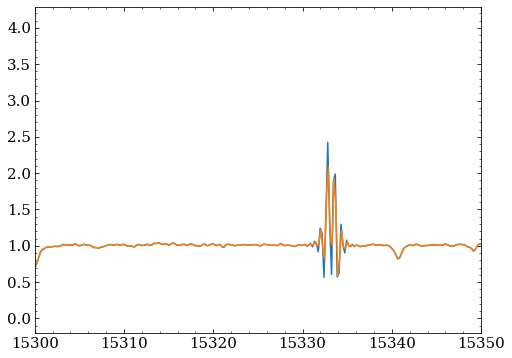

23.565107


In [55]:
fig, ax = plt.subplots(figsize = (8,6))
# ax.plot(wavs, spectrum)
ax.plot(wavs_rv, spectrum)
ax.plot(wavs, spec_interp)

ax.set_xlim(15300, 15350)
plt.show()
print(rv)

In [11]:
## ASIDE

meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

# if I change the data structure, I'll make an equivalent get_residual function
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        return 
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu # may want to make it return the path

In [12]:
meta

teff_low,teff_high,logg_low,logg_high,m_h_low,m_h_high,nstars,res_std_median,res_std_mean,fname,i_ind,j_ind,k_ind
int64,int64,float64,float64,float64,float64,int64,float64,float64,str47,int64,int64,int64
3000,3050,-1.0,-0.8,-2.3,-2.0,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,0
3000,3050,-1.0,-0.8,-2.0,-1.7,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,1
3000,3050,-1.0,-0.8,-1.7,-1.4,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,2
3000,3050,-1.0,-0.8,-1.4,-1.1,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,3
3000,3050,-1.0,-0.8,-1.1,-0.9,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,4
3000,3050,-1.0,-0.8,-0.9,-0.7,0,nan,nan,ResidualsFiles/Residuals_TeffBin3000_3050.fits,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
9950,10000,4.8,5.0,-0.9,-0.7,0,nan,nan,ResidualsFiles/Residuals_TeffBin9950_10000.fits,73,29,5
9950,10000,4.8,5.0,-0.7,-0.5,0,nan,nan,ResidualsFiles/Residuals_TeffBin9950_10000.fits,73,29,6


In [13]:
meta_new = Table(fits.open('Residuals/meta.fits')[1].data)


# if I change the data structure, I'll make an equivalent get_residual function
def get_medres(teff, logg, m_h, dir = 'Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta_new['TEFF_MIN'], teff < meta_new['TEFF_MAX'], 
                    logg >= meta_new['LOGG_MIN'], logg < meta_new['LOGG_MAX'],
                   m_h >= meta_new['M_H_MIN'], m_h < meta_new['M_H_MAX']]))[0]
    if len(rowselect) != 1:
        return 
    
    row = meta_new[rowselect]
    filename = row['FNAME'].item()
    # print(filename)
    return dir + filename
#     hdulist = fits.open(filename)
#     hdulist = np.array(hdulist)[1:].reshape(30,12)
#     hdu = hdulist[j, k].item()
#     return hdu # may want to make it return the path
    

In [14]:
res1 = get_residual(star['TEFF'], star['LOGG'], star['M_H'])
res2 = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))

In [16]:
meta_new

TEFF_MIN,TEFF_MAX,LOGG_MIN,LOGG_MAX,M_H_MIN,M_H_MAX,NBIN,STDEV_MEDIAN,STDEV_MEAN,FNAME
int64,int64,float64,float64,float64,float64,int64,float64,float64,str55
7250,7400,-1.0,-0.8,-2.3,-2.0,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-2.3_-2.0.fits
7250,7400,-1.0,-0.8,-2.0,-1.7,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-2.0_-1.7.fits
7250,7400,-1.0,-0.8,-1.7,-1.4,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-1.7_-1.4.fits
7250,7400,-1.0,-0.8,-1.4,-1.1,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-1.4_-1.1.fits
7250,7400,-1.0,-0.8,-1.1,-0.9,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-1.1_-0.9.fits
7250,7400,-1.0,-0.8,-0.9,-0.7,0,nan,nan,TEFFBIN7250_7400_LOGGBIN-1.0_-0.8_M_HBIN-0.9_-0.7.fits
...,...,...,...,...,...,...,...,...,...
5450,5600,4.8,5.0,-0.9,-0.7,0,nan,nan,TEFFBIN5450_5600_LOGGBIN4.8_5.0_M_HBIN-0.9_-0.7.fits
5450,5600,4.8,5.0,-0.7,-0.5,0,nan,nan,TEFFBIN5450_5600_LOGGBIN4.8_5.0_M_HBIN-0.7_-0.5.fits


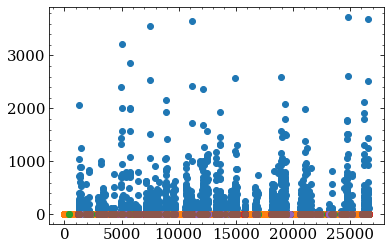

In [21]:
plt.scatter(np.arange(len(meta_new)), meta_new['NBIN'], marker= 'o')
zero = np.where(meta_new['NBIN'] == 0)[0]
notzero = np.where(meta_new['NBIN'] != 0)[0]
one = np.where(meta_new['NBIN'] == 1)[0]
two = np.where(meta_new['NBIN'] == 2)[0]
three = np.where(meta_new['NBIN'] == 3)[0]
four = np.where(meta_new['NBIN'] == 4)[0]
plt.scatter(np.arange(len(meta_new))[zero], meta_new['NBIN'][zero], marker= 'o')
plt.scatter(np.arange(len(meta_new))[one], meta_new['NBIN'][one], marker= 'o')
plt.scatter(np.arange(len(meta_new))[two], meta_new['NBIN'][two], marker= 'o')
plt.scatter(np.arange(len(meta_new))[three], meta_new['NBIN'][three], marker= 'o')
plt.scatter(np.arange(len(meta_new))[four], meta_new['NBIN'][four], marker= 'o')




plt.show()